In [2]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import re
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical

import keras_metrics

from sklearn.model_selection import train_test_split

In [112]:
data = pd.read_csv('All_Dataset - Copy.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,تستاه ل ي عدي م الاحس اس تعليق_الدراسه_في_القصيم,neut
1,اللهم كن مع اهلنا في غزه وفرج كربتهم برحمتك ي...,pos
2,الحكومه العراقيه تطلق اكثر من مئه ارهابي سعود...,neg
3,لك في سيره المجد قصه تقول ربي خالقك للبطولات ...,pos
4,سالتكم سؤال عن كيفيه اضافه رقم صديقي في خدمه ...,neg


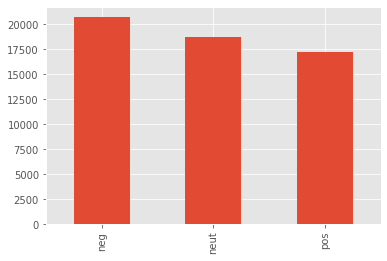

In [113]:
data['Polarity'].value_counts().sort_index().plot.bar()

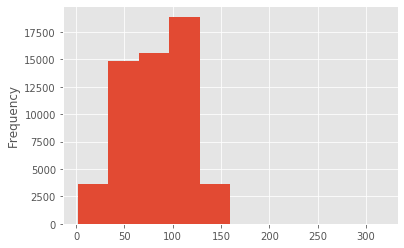

In [114]:
data['Tweet'].str.len().plot.hist()

In [115]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,تستاه ل ي عدي م الاحس اس تعليق_الدراسه_في_القصيم,neut,2
1,اللهم كن مع اهلنا في غزه وفرج كربتهم برحمتك ي...,pos,1
2,الحكومه العراقيه تطلق اكثر من مئه ارهابي سعود...,neg,0
3,لك في سيره المجد قصه تقول ربي خالقك للبطولات ...,pos,1
4,سالتكم سؤال عن كيفيه اضافه رقم صديقي في خدمه ...,neg,0


In [116]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
data['clean'] = data['clean'].apply(lambda x: re.sub('(#[أ-ي]+)|(_[أ-ي]+)', '', x, flags=re.UNICODE))

#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,تستاه ل ي عدي م الاحس اس تعليق_الدراسه_في_القصيم,neut,2,"[تستاه, عدي, الاحس, اس, تعليق]"
1,اللهم كن مع اهلنا في غزه وفرج كربتهم برحمتك ي...,pos,1,"[الهم, اهلنا, غزه, وفرج, كربتهم, برحمتك, يا, ا..."
2,الحكومه العراقيه تطلق اكثر من مئه ارهابي سعود...,neg,0,"[الحكومه, العراقيه, تطلق, مءه, ارهابي, سعودي, ..."
3,لك في سيره المجد قصه تقول ربي خالقك للبطولات ...,pos,1,"[لك, سيره, المجد, قصه, تقول, ربي, خالقك, لبطول..."
4,سالتكم سؤال عن كيفيه اضافه رقم صديقي في خدمه ...,neg,0,"[سالتكم, سوال, كيفيه, اضافه, رقم, صديقي, خدمه,..."
5,ا ف ب المانيا تعلن اعتقال شخص على صله ب هجمات_...,neut,2,"[المانيا, تعلن, اعتقال, شخص, صله, هجمات]"
6,اجمل صوره لامين منطقه القصيم بريده_تغرق هاكذا ...,pos,1,"[اجمل, صوره, لامين, منطقه, القصيم, بريده, هاكذ..."
7,الاتحاد_الخليج الهلال يفوز ع الخليج ب 7 والات...,neut,2,"[الاتحاد, الهلال, يفوز, الخليج, والاتحاد, يتعا..."
8,الفتح للحق يخرج مهزوما بالتعادل مع الهلال المغ...,neg,0,"[الفتح, لحق, يخرج, مهزوما, بالتعادل, الهلال, ا..."
9,وننتظر الشنب عزام الدخيل يغرد ب تعليق_الدراسه...,neut,2,"[ونتظر, الشنب, عزام, الدخيل, يغرد, تعليق, لبكر..."


In [117]:
CBOW = Word2Vec.load('aravec/tweets_cbow_100')
CBOWE = CBOW.wv.get_keras_embedding()

In [118]:
# def buildWordVector(tokens, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0.
#     for word in tokens:
#         try:
#             vec += CBOW[word].reshape((1, size))
#             count += 1.
#         except KeyError: # handling the case where the token is not
#             continue
#     if count != 0:
#         vec /= count
#     return vec

# X_train = np.concatenate([buildWordVector(x, 100) for x in data['clean']])
# X_train.shape

In [119]:
y = to_categorical(data['Sentiment'].values)

In [120]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
        35366, 23980, 35367,  1122,     2],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    16,  2248,   193,  9821, 18406,
         7952,     9,  1420,  8799,    49],
       [    0,     0,     0,     0,     0,     0,     0,     0,   333,
         4076,  7276, 14922,   782,   389, 35368, 11083, 12770, 35369,
        35370, 35371,   950,    64,    13],
       [    0,     0,     0,     0,     0,     0,    44,  4536,   915,
         1238,   585,   411, 23981,  3530,   619, 11084, 23982, 18407,
           60, 35372,  2892,     1,   137],
       [    0,     0,     0,     0,     0,     0,     0, 23983,   586,
         5810,  3713,   244,  3227,   269,  3227,   651, 23984,  6231,
        23985,  9822,  1827, 23986,  2103]])

In [140]:
X.shape

(56674, 23)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Prepare metrics

In [142]:
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['accuracy'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_accuracy'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [143]:
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [144]:
# metrics
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [145]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.3
EPOCHS = 20

#  Build the models

In [146]:
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [147]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

## LSTM

In [129]:
lstm_model_input = layers.Input(shape=(X_train.shape[1],))
x = CBOWE(lstm_model_input)
x = layers.LSTM(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
lstm_model = keras.models.Model(inputs=lstm_model_input, outputs=x)

In [130]:
%%time
LSTM_H = buildAndRunModel(lstm_model, 'outputs/lstm_cpkt')

Train on 26579 samples, validate on 11392 samples
Epoch 1/20
26579/26579 [==============================] - 20s 770us/step - loss: 0.9236 - accuracy: 0.5582 - precision: 0.5280 - recall: 0.2957 - f1: 0.4881 - val_loss: 0.7850 - val_accuracy: 0.6570 - val_precision: 0.6666 - val_recall: 0.5811 - val_f1: 0.6103
Epoch 2/20
26579/26579 [==============================] - 19s 708us/step - loss: 0.7394 - accuracy: 0.6809 - precision: 0.7079 - recall: 0.6018 - f1: 0.6536 - val_loss: 0.7488 - val_accuracy: 0.6724 - val_precision: 0.6597 - val_recall: 0.6466 - val_f1: 0.6435
Epoch 3/20
26579/26579 [==============================] - 21s 809us/step - loss: 0.6456 - accuracy: 0.7298 - precision: 0.7565 - recall: 0.6751 - f1: 0.7142 - val_loss: 0.7358 - val_accuracy: 0.6803 - val_precision: 0.7100 - val_recall: 0.5980 - val_f1: 0.6648
Epoch 4/20
26579/26579 [==============================] - 21s 794us/step - loss: 0.5730 - accuracy: 0.7633 - precision: 0.7989 - recall: 0.7196 - f1: 0.7550 - val_loss

In [131]:
eval_model(lstm_model)

18703/18703 [==============================] - 4s 218us/step


[(1.253755851288578, 'loss'),
 (0.6871089935302734, 'accuracy'),
 (0.7009150981903076, 'precision'),
 (0.6828129291534424, 'recall'),
 (0.6857994198799133, 'f1')]

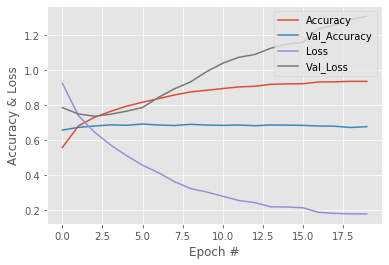

<Figure size 432x288 with 0 Axes>

In [132]:
plot_data(LSTM_H.history, EPOCHS, 'lstm')

## GRU

In [148]:
gru_model_input = layers.Input(shape=(X_train.shape[1],))
x = CBOWE(gru_model_input)
x = layers.GRU(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)

In [149]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')

Train on 26579 samples, validate on 11392 samples
Epoch 1/20
26579/26579 [==============================] - 23s 848us/step - loss: 1.0105 - accuracy: 0.5174 - precision: 0.4875 - recall: 0.3224 - f1: 0.4590 - val_loss: 0.8170 - val_accuracy: 0.6282 - val_precision: 0.6181 - val_recall: 0.5667 - val_f1: 0.5901
Epoch 2/20
26579/26579 [==============================] - 20s 766us/step - loss: 0.7714 - accuracy: 0.6653 - precision: 0.6827 - recall: 0.5803 - f1: 0.6390 - val_loss: 0.7489 - val_accuracy: 0.6740 - val_precision: 0.6936 - val_recall: 0.6005 - val_f1: 0.6471
Epoch 3/20
26579/26579 [==============================] - 20s 762us/step - loss: 0.6690 - accuracy: 0.7180 - precision: 0.7450 - recall: 0.6506 - f1: 0.7030 - val_loss: 0.7502 - val_accuracy: 0.6771 - val_precision: 0.6670 - val_recall: 0.6648 - val_f1: 0.6611
Epoch 4/20
26579/26579 [==============================] - 21s 809us/step - loss: 0.5928 - accuracy: 0.7577 - precision: 0.7793 - recall: 0.7171 - f1: 0.7497 - val_loss

In [150]:
eval_model(gru_model)

18703/18703 [==============================] - 4s 208us/step


[(1.393795346937122, 'loss'),
 (0.6646527051925659, 'accuracy'),
 (0.6813520789146423, 'precision'),
 (0.6747415661811829, 'recall'),
 (0.6622801423072815, 'f1')]

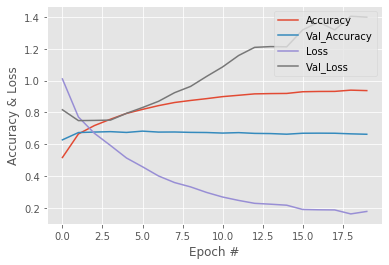

<Figure size 432x288 with 0 Axes>

In [156]:
plot_data(GRU_H.history, EPOCHS, 'gru')

In [154]:
lstm_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 23)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 23, 100)           33167900  
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 303       
Total params: 33,248,603
Trainable params: 80,703
Non-trainable params: 33,167,900
_________________________________________________________________


In [155]:
gru_model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 23)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 23, 100)           33167900  
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 33,228,503
Trainable params: 60,603
Non-trainable params: 33,167,900
_________________________________________________________________
